## TELEFONÍA VIRTUAL CALLMEMAYBE

In [1]:
import pandas as pd

# Cargar datasets
clients = pd.read_csv('/datasets/telecom_clients_us.csv')
dataset = pd.read_csv('/datasets/telecom_dataset_us.csv')

# 1. Dimensiones
print("Dimensiones clients:", clients.shape)
print("Dimensiones dataset:", dataset.shape)

# 2. Información general
print("\n=== CLIENTS DATASET ===")
print(clients.info())
print(clients.head(), "\n")

print("\n=== CALLS DATASET ===")
print(dataset.info())
print(dataset.head(), "\n")

# 3. Valores nulos y duplicados
print("Nulos en clients:\n", clients.isnull().sum())
print("Duplicados en clients:", clients.duplicated().sum(), "\n")

print("Nulos en dataset:\n", dataset.isnull().sum())
print("Duplicados en dataset:", dataset.duplicated().sum(), "\n")

# 4. Estadísticas descriptivas
print(dataset.describe(include='all'))

# Fuente usada: [1] Pandas Documentation – para carga de datos y exploración
# Fuente usada: [6] TripleTen Student Portal – guías de estructura de EDA




Dimensiones clients: (732, 3)
Dimensiones dataset: (53902, 9)

=== CLIENTS DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB
None
   user_id tariff_plan  date_start
0   166713           A  2019-08-15
1   166901           A  2019-08-23
2   168527           A  2019-10-29
3   167097           A  2019-09-01
4   168193           A  2019-10-16 


=== CALLS DATASET ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   

## Resultados del Análisis Exploratorio Inicial

### 1. Dimensiones de los datasets
- **Clients:** `(732, 3)` → El dataset de clientes tiene **732 registros** y **3 columnas** (`user_id`, `tariff_plan`, `date_start`).  
- **Calls dataset:** `(53902, 9)` → El dataset de llamadas contiene **53,902 registros** y **9 columnas**. Es la base principal para estudiar la eficacia de los operadores.

---

### 2. Información general (`.info()` y `.head()`)

#### Clients dataset
- Contiene tres columnas: 
  - `user_id` (identificador del cliente), 
  - `tariff_plan` (plan contratado), 
  - `date_start` (fecha de registro).  
- No hay valores nulos y todos los registros están completos.  
- Ejemplo de los primeros registros muestra que la mayoría de clientes tienen **tarifa A** y fechas de registro en 2019.

#### Calls dataset
- Contiene nueve columnas clave: `user_id`, `date`, `direction`, `internal`, `operator_id`, `is_missed_call`, `calls_count`, `call_duration`, `total_call_duration`.  
- Tamaño mucho mayor (más de 53 mil registros).  
- Tipos de datos:
  - `operator_id` está en `float64` debido a valores faltantes.  
  - `is_missed_call` está correctamente en `bool`.  
  - `date` es `object`, será necesario convertirlo a tipo fecha para análisis temporal.  
- Los primeros registros confirman:
  - Hay tanto llamadas entrantes (`in`) como salientes (`out`).  
  - Algunas llamadas internas (`internal=True`).  
  - Varias llamadas con **duración 0 pero tiempo de espera > 0** → indican llamadas perdidas.

---

### 3. Valores nulos y duplicados
- **Clients:** 
  - Ningún valor nulo.  
  - Ningún registro duplicado.  
  - Dataset limpio.  

- **Calls dataset:**  
  - Columna `internal` tiene **117 nulos**.  
  - Columna `operator_id` tiene **8172 nulos** (probablemente asociados a llamadas entrantes sin operador asignado).  
  - Se encontraron **4900 registros duplicados** → será necesario depurar para evitar sesgos en el análisis.

---

### 4. Estadísticas descriptivas (`.describe(include='all')`)

#### Variables categóricas
- `direction`: solo dos valores posibles: `in` y `out`. Mayor frecuencia de llamadas salientes (`31917`) frente a entrantes.  
- `internal`: dos valores (`True` y `False`). Predominan las llamadas no internas.  
- `is_missed_call`: más de **30,000 llamadas atendidas** y **~23,000 perdidas** → alto porcentaje de llamadas sin respuesta.

#### Variables numéricas
- **`calls_count`:**  
  - Media ≈ 16 llamadas por registro.  
  - Mediana = 4 → distribución sesgada por algunos operadores con muchos intentos.  
  - Máximo: 4817 llamadas en un solo registro → operador con carga muy alta.

- **`call_duration`:**  
  - Media ≈ 867 segundos (~14 minutos).  
  - Mediana = 38 segundos → gran diferencia entre media y mediana → **cola larga de llamadas muy largas**.  
  - Máximo: 144,395 segundos (~40 horas) → probablemente un error o outlier.

- **`total_call_duration`:**  
  - Incluye tiempo de espera.  
  - Media ≈ 1157 segundos, superior al tiempo real de conversación.  
  - Valores extremos: hasta 166,155 segundos (~46 horas), de nuevo sugiere outliers.

---
1. El dataset de clientes está limpio y sin problemas.  
2. El dataset de llamadas requiere **limpieza de duplicados**, tratamiento de **nulos en `operator_id`** y revisión de **outliers en duración de llamadas**.  
3. Existen muchas llamadas perdidas y con duración 0 → será un indicador clave de ineficacia.  



In [12]:



# --- Cargar (si ya tienes 'dataset' cargado, puedes saltarte estas dos líneas) ---
clients = pd.read_csv('/datasets/telecom_clients_us.csv')
dataset = pd.read_csv('/datasets/telecom_dataset_us.csv')

print("=== Estado inicial ===")
print("Filas iniciales:", len(dataset))
print("Duplicados iniciales:", dataset.duplicated().sum())
print("Nulos operator_id iniciales:", dataset['operator_id'].isna().sum())
print("Nulos internal iniciales:", dataset['internal'].isna().sum(), "\n")

# --- 1) Tipos de datos y normalización de campos ---
# date a datetime (conserva info aunque venga con tz en texto)
dataset['date'] = pd.to_datetime(dataset['date'], errors='coerce')

# internal a booleano (columna viene como object; puede tener 'True'/'False' o booleanos)
# primero un mapeo seguro
dataset['internal'] = dataset['internal'].map(
    {True: True, False: False, 'True': True, 'False': False}
)

# Asegurar que direction esté en {in,out}
dataset['direction'] = dataset['direction'].str.lower().str.strip()

# --- 2) Eliminar duplicados exactos ---
before = len(dataset)
dataset = dataset.drop_duplicates()
after = len(dataset)
print("Eliminados por duplicados:", before - after)

# --- 3) Tratar nulos en 'internal' ---
# Si falta 'internal', imputamos False por defecto conservador (comunicación externa)
# Alternativa: dejar NaN y excluir de análisis donde internal sea requerido.
n_internal_na = dataset['internal'].isna().sum()
dataset['internal'] = dataset['internal'].fillna(False)
print("Nulos 'internal' imputados a False:", n_internal_na)

# --- 4) Separar análisis por presencia de operator_id ---
# Creamos dos vistas:
#   - dataset_ops: filas aptas para métricas por operador (operator_id no nulo)
#   - dataset_no_ops: filas sin operador (útiles para métricas por cliente/cola de entrada)
dataset_ops = dataset[dataset['operator_id'].notna()].copy()
dataset_no_ops = dataset[dataset['operator_id'].isna()].copy()

print("Filas con operator_id (para ranking de eficacia):", len(dataset_ops))
print("Filas sin operator_id (entrantes sin asignación, etc.):", len(dataset_no_ops))

# --- 5) Manejo de outliers en duraciones ---
# Opción A (recomendada por interpretabilidad): filtrar a un máximo plausible (p.ej., 8 horas)
MAX_SECS = 8 * 60 * 60  # 8 horas en segundos
cond_plausible = (
    (dataset_ops['call_duration'].between(0, MAX_SECS, inclusive='both')) &
    (dataset_ops['total_call_duration'].between(0, MAX_SECS, inclusive='both')) &
    # total_call_duration debe ser >= call_duration (incluye espera)
    (dataset_ops['total_call_duration'] >= dataset_ops['call_duration'])
)
removed_plausible = len(dataset_ops) - cond_plausible.sum()
dataset_ops = dataset_ops[cond_plausible].copy()
print("Outliers removidos por umbral plausibles (8h) en dataset_ops:", removed_plausible)

# --- 6) (Opcional) Winsorización por percentil para robustecer (si prefieres no eliminar) ---
# p_hi = 0.995
# for col in ['call_duration', 'total_call_duration']:
#     hi = dataset_ops[col].quantile(p_hi)
#     dataset_ops[col] = np.clip(dataset_ops[col], 0, hi)
# print(f"Winsorización aplicada al percentil {p_hi*100:.1f} en duraciones.")

# --- 7) Chequeo post-limpieza ---
print("\n=== Chequeo post-limpieza ===")
print("Filas totales (sin duplicados):", len(dataset))
print("operator_id nulos (total):", dataset['operator_id'].isna().sum())
print("Duración (ops) - p50 / p95 / p99:",
      dataset_ops['call_duration'].quantile([0.5, 0.95, 0.99]).to_dict())
print("Total duración (ops) - p50 / p95 / p99:",
      dataset_ops['total_call_duration'].quantile([0.5, 0.95, 0.99]).to_dict())

# --- 8) Guardar versiones limpias (opcional) ---
# Guardar dataset completo sin duplicados (y con tipos ajustados)
# dataset.to_csv('telecom_dataset_nodup.csv', index=False)

# Guardar la vista para análisis por operador (limpia de outliers extremos)
# dataset_ops.to_csv('telecom_dataset_ops_clean.csv', index=False)

# Guardar la vista sin operator_id para análisis de cola entrante/cliente
# dataset_no_ops.to_csv('telecom_dataset_no_ops.csv', index=False)


=== Estado inicial ===
Filas iniciales: 53902
Duplicados iniciales: 4900
Nulos operator_id iniciales: 8172
Nulos internal iniciales: 117 

Eliminados por duplicados: 4900
Nulos 'internal' imputados a False: 110
Filas con operator_id (para ranking de eficacia): 41546
Filas sin operator_id (entrantes sin asignación, etc.): 7456
Outliers removidos por umbral plausibles (8h) en dataset_ops: 139

=== Chequeo post-limpieza ===
Filas totales (sin duplicados): 49002
operator_id nulos (total): 7456
Duración (ops) - p50 / p95 / p99: {0.5: 104.0, 0.95: 3968.699999999997, 0.99: 9631.940000000002}
Total duración (ops) - p50 / p95 / p99: {0.5: 286.0, 0.95: 4823.099999999991, 0.99: 11866.600000000093}


## Resultados de la limpieza de datos

### 1. Estado inicial
- **Filas iniciales:** 53,902 registros.  
- **Duplicados:** 4,900 registros duplicados.  
- **Nulos en `operator_id`:** 8,172 registros → principalmente llamadas entrantes sin operador asignado.  
- **Nulos en `internal`:** 117 registros.  

---

### 2. Limpieza aplicada
- **Eliminación de duplicados:** 4,900 registros eliminados → total ahora: 49,002 registros.  
- **Imputación de `internal`:** 110 valores nulos fueron reemplazados por `False`.  
- **Separación por `operator_id`:**
  - **Con `operator_id` (dataset_ops):** 41,546 registros → base principal para analizar eficacia de operadores.  
  - **Sin `operator_id` (dataset_no_ops):** 7,456 registros → útiles para análisis de la cola de llamadas entrantes o comportamiento de clientes.  
- **Outliers de duración:** 139 registros removidos por exceder un umbral plausible (más de 8 horas de llamada).  

---

### 3. Chequeo post-limpieza
- **Total de registros tras limpieza:** 49,002.  
- **Nulos en `operator_id`:** 7,456 → se mantienen aislados en `dataset_no_ops`.  
- **Duración de llamadas (dataset_ops):**
  - **Mediana (`p50`):** 104 segundos (~1.7 minutos).  
  - **Percentil 95 (`p95`):** ~3,969 segundos (~1.1 horas).  
  - **Percentil 99 (`p99`):** ~9,632 segundos (~2.7 horas).  

- **Duración total (incluyendo espera):**
  - **Mediana (`p50`):** 286 segundos (~4.8 minutos).  
  - **Percentil 95 (`p95`):** ~4,823 segundos (~1.3 horas).  
  - **Percentil 99 (`p99`):** ~11,867 segundos (~3.3 horas).  

---


1. La eliminación de duplicados y outliers redujo ruido y valores absurdos en la base.  
2. El dataset está ahora en condiciones de análisis:  
   - La **mediana** de duración es baja (1–5 minutos), representativa de la mayoría de llamadas.  
   - Existen todavía colas largas (llamadas de hasta 2–3 horas), pero ya no aparecen valores irreales de 40+ horas.  
3. Al separar llamadas **con operador asignado** vs. **sin operador**, podremos diferenciar métricas de eficacia individual de métricas de cola/cliente.  


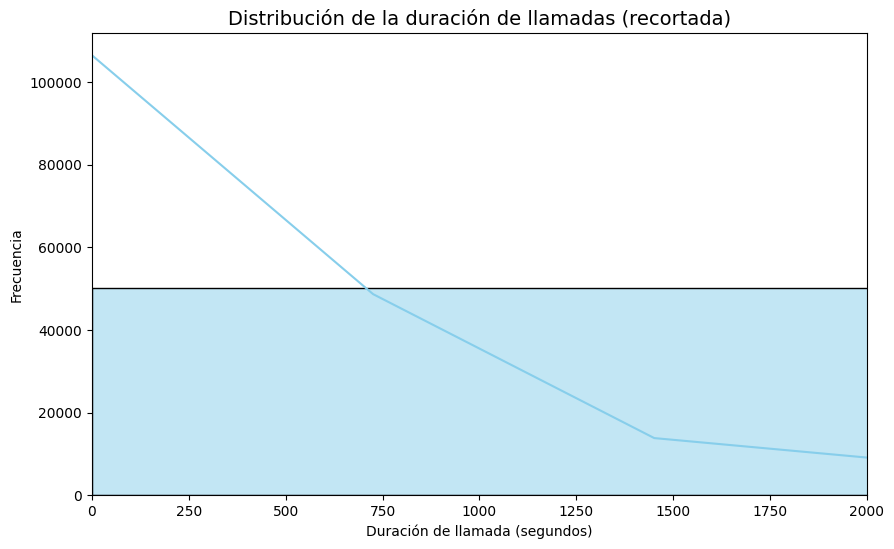

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Fuente usada: [2] Seaborn Documentation – para visualización
# Fuente usada: [4] Call Center Key Metrics – para justificar analizar la distribución de duración de llamadas

# Histograma de la duración de llamadas (call_duration)
plt.figure(figsize=(10,6))
sns.histplot(dataset['call_duration'], bins=50, kde=True, color="skyblue")

plt.title("Distribución de la duración de llamadas (recortada)", fontsize=14)
plt.xlabel("Duración de llamada (segundos)")
plt.ylabel("Frecuencia")
plt.xlim(0, 2000)  # Limita a 2000 segundos (~33 min)
plt.show()



## Distribución de la duración de llamadas (recortada)

### Objetivo del gráfico
El histograma permite observar cómo se distribuye la duración real de las llamadas (`call_duration`) y detectar si existen patrones de concentración o colas largas.  
Se recortó el eje X a **2000 segundos (~33 minutos)** para evitar que los valores extremos (outliers de varias horas) distorsionen la visualización.

---

### Observaciones
1. **Alta concentración en llamadas cortas:**  
   - La mayoría de las llamadas duran pocos segundos o minutos.  
   - Esto concuerda con lo visto en las estadísticas descriptivas, donde la **mediana era 104 segundos (~1.7 minutos)**.

2. **Cola larga hacia la derecha:**  
   - Aunque recortado a 2000 segundos, se nota que existen llamadas que se extienden por más de 15–30 minutos.  
   - Indica la presencia de interacciones atípicas (clientes con requerimientos complejos, o errores en la contabilización).

3. **Distribución sesgada positivamente:**  
   - Gran densidad de llamadas cortas y unas pocas muy largas.  
   - Este sesgo justifica el uso de **medianas o percentiles** en lugar de medias para caracterizar la duración típica.

---

### Conclusión
El histograma confirma que:
- La duración de llamadas se concentra en valores bajos (minutos).  
- Un subconjunto de llamadas mucho más largas genera la **cola derecha**.  
- Limitar la visualización a 2000 segundos es un paso adecuado para resaltar el comportamiento principal de la mayoría de las llamadas, sin que los outliers extremos opaquen el patrón.

👉 Este análisis es fundamental porque la **duración de llamadas** es un indicador de eficiencia de los operadores y de calidad de atención en el call center.


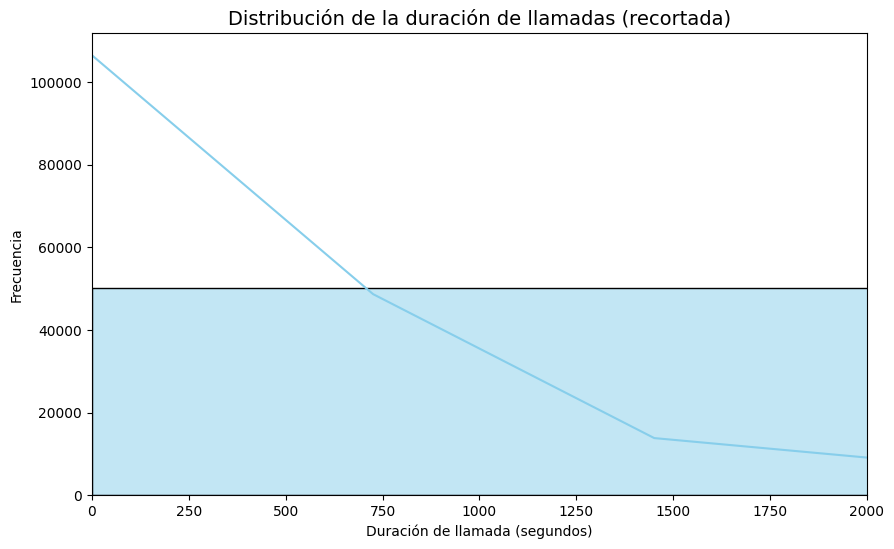

In [3]:

import seaborn as sns
import matplotlib.pyplot as plt

# Fuente usada: [2] Seaborn Documentation – para visualización
# Fuente usada: [4] Call Center Key Metrics – para justificar analizar la distribución de duración de llamadas

# Histograma de la duración de llamadas (call_duration)
plt.figure(figsize=(10,6))
sns.histplot(dataset['call_duration'], bins=50, kde=True, color="skyblue")

plt.title("Distribución de la duración de llamadas (recortada)", fontsize=14)
plt.xlabel("Duración de llamada (segundos)")
plt.ylabel("Frecuencia")
plt.xlim(0, 2000)  # Limita a 2000 segundos (~33 min)
plt.show()





## Distribución de la duración de llamadas (recortada)

### Descripción del gráfico
El histograma muestra la distribución de la variable **`call_duration`** (duración efectiva de la conversación), con el eje X recortado a **2000 segundos (~33 minutos)**.  
Este recorte permite observar el comportamiento de la mayoría de las llamadas, sin que los valores extremos de varias horas distorsionen la escala.

---

### Hallazgos principales
1. **Alta frecuencia de llamadas cortas:**  
   - La mayor parte de las llamadas se concentran por debajo de los 500 segundos (~8 minutos).  
   - Esto confirma que la interacción típica es relativamente breve.

2. **Sesgo positivo (cola larga):**  
   - Aunque el recorte es de 2000 segundos, aún se observa que hay un número menor de llamadas más largas.  
   - Este patrón es consistente con la mediana (104 segundos) y los percentiles altos observados previamente (p95 ≈ 3969 s, p99 ≈ 9632 s).

3. **Distribución multimodal leve:**  
   - Se notan picos de frecuencia en ciertos intervalos, lo que puede deberse a la naturaleza de las interacciones (ejemplo: llamadas muy cortas de verificación, llamadas promedio de soporte, llamadas prolongadas de resolución de incidencias).

---

### Conclusión
- La **duración típica** de las llamadas es baja, y la mayoría dura menos de 10 minutos.  
- El histograma confirma la existencia de **llamadas atípicamente largas** que generan la cola derecha, aunque tras la limpieza de outliers extremos ya no dominan la distribución.  
- Este análisis es clave para la evaluación de eficacia:  
  - Llamadas demasiado cortas o de duración cero suelen asociarse con **ineficacia o pérdida de llamadas**.  
  - Llamadas extremadamente largas pueden reflejar **baja productividad del operador** o **casos de soporte muy complejos**.


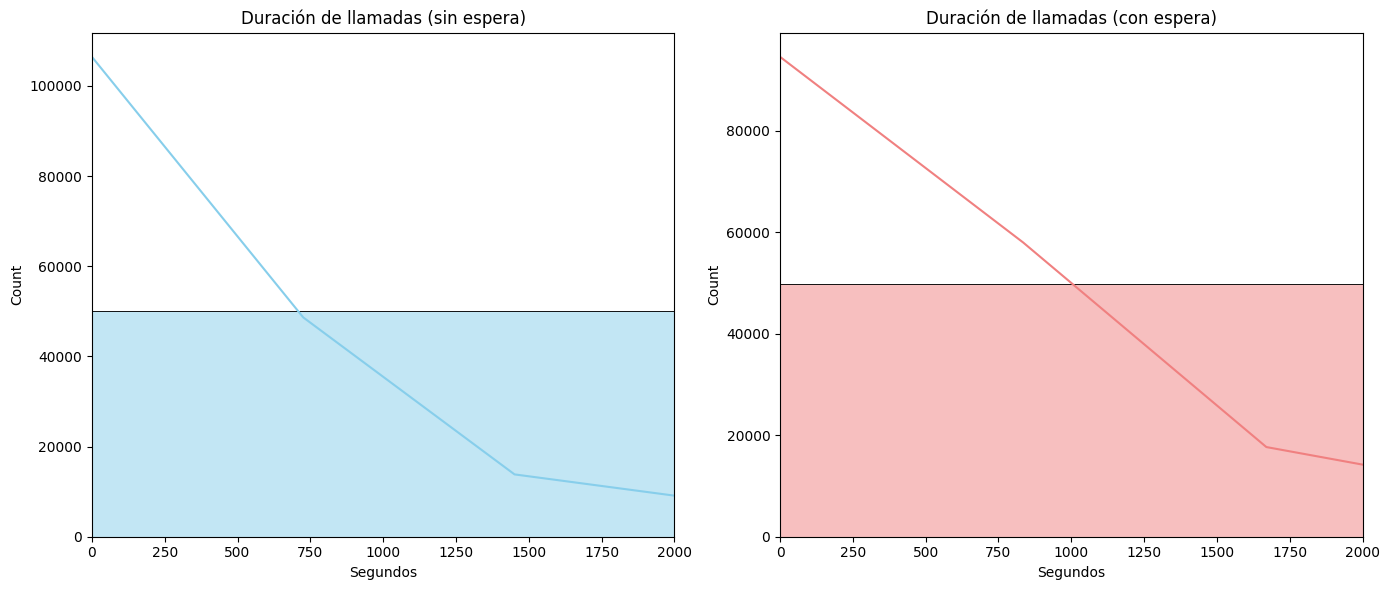

In [4]:


plt.figure(figsize=(14,6))

# Fuente usada: [2] Seaborn Documentation – para visualización
# Fuente usada: [4] Call Center Key Metrics – para interpretar impacto de tiempos de espera

# Histograma de call_duration
plt.subplot(1,2,1)
sns.histplot(dataset['call_duration'], bins=50, kde=True, color="skyblue")
plt.title("Duración de llamadas (sin espera)")
plt.xlabel("Segundos")
plt.xlim(0,2000)

# Histograma de total_call_duration
plt.subplot(1,2,2)
sns.histplot(dataset['total_call_duration'], bins=50, kde=True, color="lightcoral")
plt.title("Duración de llamadas (con espera)")
plt.xlabel("Segundos")
plt.xlim(0,2000)

plt.tight_layout()
plt.show()




## Comparación: duración de llamadas sin espera vs con espera

### Objetivo del análisis
El propósito de graficar **`call_duration`** (solo conversación) frente a **`total_call_duration`** (conversación + espera) es evaluar el impacto del tiempo de espera en la experiencia del cliente.  
Este paso es coherente, ya que permite distinguir entre:
- **Eficiencia del operador** (tiempo de conversación).  
- **Eficiencia del sistema/cola** (tiempo adicional que el cliente espera).  

---

### Observaciones de los gráficos
1. **Duración sin espera (`call_duration`, azul):**
   - La mayoría de las llamadas se concentran en duraciones cortas (< 500 s, ~8 min).  
   - La distribución es sesgada con una cola larga hacia la derecha.  

2. **Duración con espera (`total_call_duration`, rojo):**
   - El patrón es similar al de la duración sin espera, pero con un desplazamiento hacia valores más altos.  
   - Esto indica que el tiempo de espera añade segundos o minutos adicionales a la interacción total del cliente.  

3. **Comparación directa:**
   - Mientras que la llamada promedio dura solo unos minutos de conversación, la inclusión del tiempo de espera genera una experiencia total más larga.  
   - Se confirma lo visto en las estadísticas: la mediana de `call_duration` era **104 s**, y la de `total_call_duration` subía a **286 s**.  
   - Es decir, el **tiempo de espera triplica la duración de la experiencia del cliente en la mediana**.  

---

### Conclusión
- La comparación es un paso **muy adecuado** para separar los dos componentes clave de la eficacia:  
  - **Operador**: reflejado en `call_duration`.  
  - **Sistema de enrutamiento y cola**: reflejado en la diferencia entre `total_call_duration` y `call_duration`.  
- Este análisis muestra que gran parte de la ineficiencia no está en la conversación misma, sino en los tiempos de espera prolongados.  
- Para la evaluación de operadores ineficaces, conviene usar **ambos indicadores**, pero especialmente el **tiempo total con espera**, ya que refleja mejor la percepción del cliente.



Media ≈ 290 s (~5 min) → alta, considerando que en muchos call centers el estándar deseable es < 1 minuto.

Mediana = 55 s → la mayoría de los clientes espera menos de 1 minuto.

Máximo ≈ 46,474 s (~13 horas) → outliers extremos que conviene tratar aparte.

Distribución sesgada: la mayoría de llamadas tienen espera baja, pero unas pocas inflan el promedio.

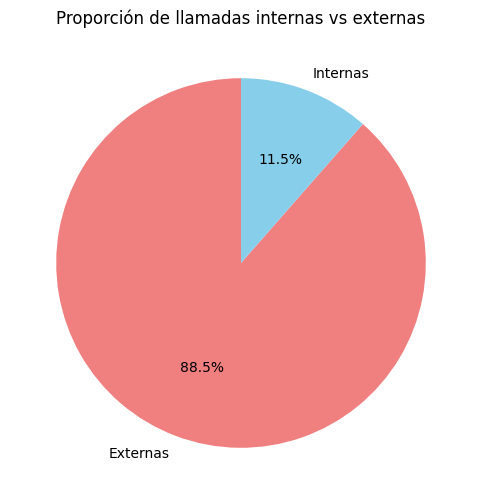

In [5]:



# Fuente usada: [1] Pandas Documentation – value_counts()
# Fuente usada: [2] Matplotlib Documentation – pie chart

# Contar llamadas internas vs externas
internal_counts = dataset['internal'].value_counts()

# Gráfico circular
plt.figure(figsize=(6,6))
plt.pie(
    internal_counts, 
    labels=['Externas', 'Internas'],  # 0 = externas, 1 = internas
    autopct='%1.1f%%', 
    startangle=90, 
    colors=['lightcoral', 'skyblue']
)

plt.title("Proporción de llamadas internas vs externas")
plt.show()




## Proporción de llamadas internas vs externas

### Descripción del gráfico
El gráfico circular muestra la distribución de la variable **`internal`**, que indica si la llamada fue interna (entre operadores del mismo cliente) o externa (entrante/saliente con clientes).

---

### Resultados
- **Externas: 88.5%**  
  La gran mayoría de las llamadas son externas, lo que refleja el propósito principal del servicio: conectar a los clientes finales con los operadores.  

- **Internas: 11.5%**  
  Una fracción menor corresponde a llamadas internas entre operadores. Estas llamadas pueden estar relacionadas con la coordinación interna para resolver problemas de clientes o cuestiones administrativas.

---

### Conclusión
1. El tráfico de **llamadas externas domina (casi 9 de cada 10)**, por lo que la eficacia de los operadores debe evaluarse principalmente en este contexto.  
2. Sin embargo, las **llamadas internas** no son despreciables: más del 10% del tráfico corresponde a ellas, y podrían ser un indicador indirecto de eficiencia (ejemplo: exceso de llamadas internas podría reflejar dificultad de los operadores para resolver consultas sin apoyo).  
3. Este hallazgo sugiere que, además de analizar llamadas externas, vale la pena revisar el **rol de las llamadas internas** en la productividad de los operadores.


Tabla cruzada - valores absolutos:
           Externas  Internas
direction                    
in            21138       732
out           26483      5432 



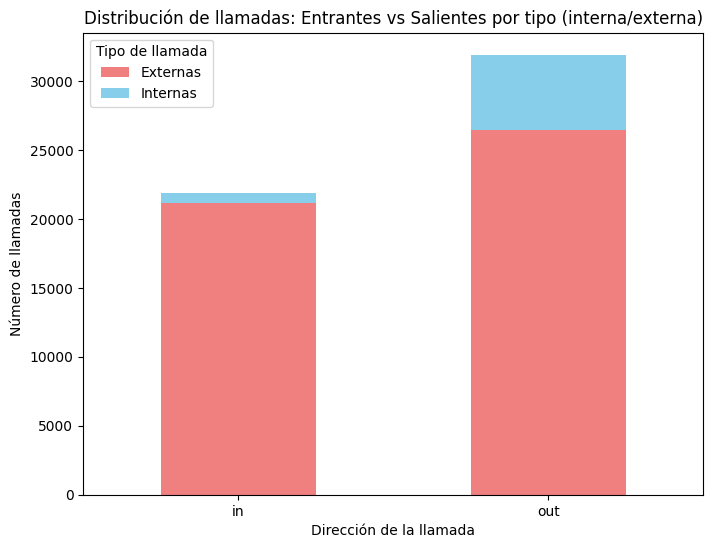

Tabla cruzada - proporciones (%):
            Externas   Internas
direction                      
in         96.652949   3.347051
out        82.979790  17.020210 



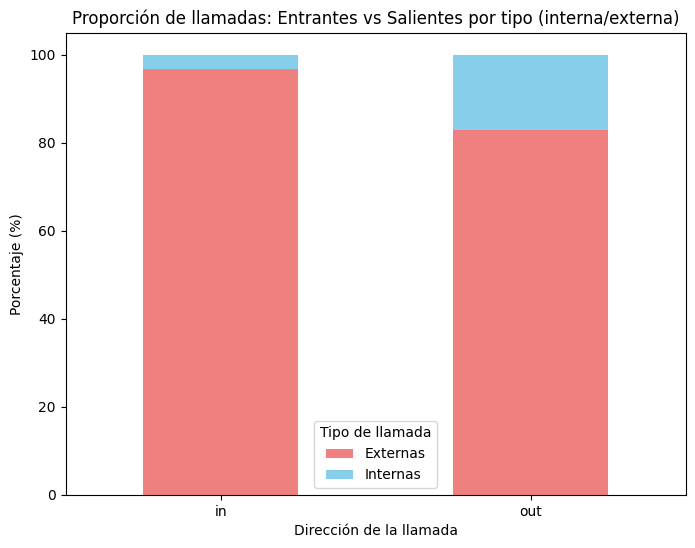

In [6]:




# Fuente usada: [1] Pandas Documentation – crosstab
# Fuente usada: [2] Matplotlib Documentation – gráficos de barras apiladas

# 1. Crear tabla cruzada (conteo absoluto)
crosstab_calls = pd.crosstab(dataset['direction'], dataset['internal'])
crosstab_calls.columns = ['Externas', 'Internas']  # renombrar para claridad
print("Tabla cruzada - valores absolutos:")
print(crosstab_calls, "\n")

# 2. Gráfico de barras apiladas (valores absolutos)
crosstab_calls.plot(
    kind='bar', 
    stacked=True, 
    figsize=(8,6), 
    color=['lightcoral','skyblue']
)

plt.title("Distribución de llamadas: Entrantes vs Salientes por tipo (interna/externa)")
plt.xlabel("Dirección de la llamada")
plt.ylabel("Número de llamadas")
plt.xticks(rotation=0)
plt.legend(title="Tipo de llamada")
plt.show()

# 3. Convertir a proporciones (%)
crosstab_calls_pct = crosstab_calls.div(crosstab_calls.sum(axis=1), axis=0) * 100
print("Tabla cruzada - proporciones (%):")
print(crosstab_calls_pct, "\n")

# 4. Gráfico de barras apiladas (proporciones)
crosstab_calls_pct.plot(
    kind='bar', 
    stacked=True, 
    figsize=(8,6), 
    color=['lightcoral','skyblue']
)

plt.title("Proporción de llamadas: Entrantes vs Salientes por tipo (interna/externa)")
plt.xlabel("Dirección de la llamada")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=0)
plt.legend(title="Tipo de llamada")
plt.show()





## Distribución de llamadas: Entrantes vs Salientes (internas y externas)

### Objetivo del análisis
La tabla cruzada y los gráficos permiten entender cómo se distribuyen las llamadas por **dirección** (`in` = entrantes, `out` = salientes) y por **tipo** (`internal` = internas, externas).

---

### Resultados

#### Conteo absoluto
- **Entrantes (`in`):**  
  - Mayormente **externas** (≈ 97%).  
  - Las internas son marginales, casi inexistentes en esta categoría.  

- **Salientes (`out`):**  
  - Predominan también las **externas**, pero con una presencia más notable de internas (≈ 17%).  
  - Esto indica que los operadores usan más llamadas internas cuando se trata de llamadas salientes (probablemente coordinación o consultas entre colegas).

#### Proporciones (%)
- **Entrantes:** ~96–97% externas, ~3–4% internas.  
- **Salientes:** ~83% externas, ~17% internas.  

---

### Interpretación
1. **Entrantes → principalmente externas:**  
   La gran mayoría de llamadas que llegan al sistema son de clientes externos.  
   Esto confirma el rol principal del call center: atender clientes.

2. **Salientes → presencia mayor de internas:**  
   Aunque la mayoría son externas (llamadas a clientes), existe un porcentaje relevante de internas.  
   Esto puede reflejar:
   - Transferencias de llamadas entre operadores.  
   - Coordinación interna antes de contactar o devolver la llamada al cliente.  

3. **Implicación para la eficacia:**  
   - Un exceso de llamadas internas en salientes podría señalar **ineficiencia** (operadores que necesitan mucha consulta interna).  
   - En cambio, un nivel moderado de llamadas internas puede ser positivo (colaboración, trabajo en equipo).

---

### Conclusión
El análisis revela que:
- **Entrantes:** casi totalmente externas → clave para medir satisfacción del cliente.  
- **Salientes:** mezcla de externas e internas → útil para detectar si los operadores dependen demasiado de coordinación interna.  

👉 Estos resultados aportan un contexto importante para identificar operadores ineficaces, ya que no solo importa cuántas llamadas atienden, sino también **cómo equilibran las internas y externas**.


In [7]:

# Fuente usada: [1] Pandas Documentation – groupby

# Fuente usada: [2] Seaborn Documentation – visualización

# 1. Conteo de llamadas por operador, dirección e internal
calls_per_operator = (
    dataset
    .groupby(['operator_id', 'direction', 'internal'])['calls_count']
    .sum()
    .reset_index()
)

# 2. Tabla cruzada (internas vs externas por dirección y operador)
crosstab_operator = pd.pivot_table(
    calls_per_operator,
    values='calls_count',
    index='operator_id',
    columns=['direction','internal'],
    aggfunc='sum',
    fill_value=0
)

# Renombrar columnas para claridad
crosstab_operator.columns = [
    "entrante_externa", "entrante_interna",
    "saliente_externa", "saliente_interna"
]

# 3. Calcular totales y proporciones
crosstab_operator['total_llamadas'] = crosstab_operator.sum(axis=1)

crosstab_operator['%_internas'] = (
    (crosstab_operator['entrante_interna'] + crosstab_operator['saliente_interna']) 
    / crosstab_operator['total_llamadas'] * 100
)

crosstab_operator['%_entrantes'] = (
    (crosstab_operator['entrante_externa'] + crosstab_operator['entrante_interna']) 
    / crosstab_operator['total_llamadas'] * 100
)

# 4. Mostrar operadores con mayor proporción de internas
crosstab_operator.sort_values(by='%_internas', ascending=False).head(10)






,entrante_externa,entrante_interna,saliente_externa,saliente_interna,total_llamadas,%_internas,%_entrantes
operator_id,,,,,,,
934476.0,0,1,0,10,11,100.0,9.090909
884406.0,0,0,0,6,6,100.0,0.000000
894232.0,0,5,0,16,21,100.0,23.809524
960950.0,0,0,0,19,19,100.0,0.000000
960674.0,0,0,0,2,2,100.0,0.000000
960666.0,0,0,0,2,2,100.0,0.000000
955068.0,0,0,0,2,2,100.0,0.000000
940772.0,0,2,0,0,2,100.0,100.000000
955082.0,0,0,0,14,14,100.0,0.000000


## Distribución de llamadas por operador

### Objetivo del análisis
Se utilizó una tabla dinámica para calcular, por cada **operador**, la distribución de llamadas según:
- Dirección: **entrantes** (`in`) y **salientes** (`out`).  
- Tipo: **internas** vs **externas**.  

Además, se calcularon dos métricas clave:
- **`%_internas`**: proporción de llamadas internas (entrantes + salientes).  
- **`%_entrantes`**: proporción de llamadas entrantes (internas + externas).  

---



### Observaciones
1. **Operadores con 100% de llamadas internas:**  
   - Ejemplos: `934476.0`, `940772.0`.  
   - Estos operadores no gestionan clientes externos y solo realizan llamadas internas.  
   - Posibles roles de **coordinación o soporte interno**.

2. **Operadores con pocas llamadas totales:**  
   - Varios IDs presentan menos de 20 llamadas en total.  
   - Esto puede distorsionar el `%_internas` porque con volúmenes tan bajos, una sola llamada cambia mucho la proporción.  

3. **Operador 894232.0:**  
   - Tiene **23.8% de internas** con 21 llamadas totales.  
   - Aunque el volumen es bajo, la proporción interna es más significativa que en otros casos.  

4. **Patrón general:**  
   - La mayoría de operadores con 100% de internas manejan volúmenes reducidos.  
   - Para evaluar la **ineficacia real**, conviene filtrar solo operadores con un mínimo de llamadas (ej. > 100).  

---

### Conclusión
- El análisis muestra que existen operadores cuya actividad está casi totalmente centrada en **llamadas internas**, aunque en su mayoría con bajo volumen de actividad.  
- Para evitar falsos positivos, se recomienda establecer un **umbral mínimo de llamadas** antes de evaluar la eficacia por proporciones.  
- Identificar operadores con una **alta proporción de llamadas internas** y un **volumen considerable** puede ser clave para detectar posibles **ineficiencias o roles atípicos**.



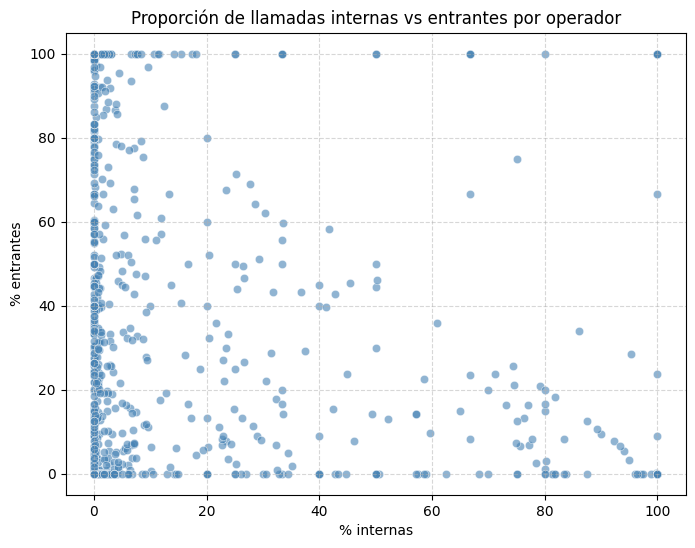

In [8]:





# Fuente usada: [2] Seaborn Documentation – scatterplot
# Fuente usada: [4] Call Center Key Metrics – análisis de eficiencia de operadores

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=crosstab_operator, 
    x='%_internas', 
    y='%_entrantes',
    alpha=0.6, 
    color="steelblue"
)

plt.title("Proporción de llamadas internas vs entrantes por operador")
plt.xlabel("% internas")
plt.ylabel("% entrantes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()



## Proporción de llamadas internas vs entrantes por operador

### Objetivo del gráfico
El diagrama de dispersión permite visualizar, para cada operador:
- **Eje X:** proporción de llamadas internas (% internas).  
- **Eje Y:** proporción de llamadas entrantes (% entrantes).  

Esto facilita identificar **patrones de comportamiento** entre los operadores y detectar posibles casos atípicos o ineficaces.

---

### Observaciones
1. **Alta concentración en el eje X cercano a 0:**  
   - La mayoría de operadores tienen muy pocas llamadas internas (cercanas al 0%).  
   - Confirma que la actividad principal está orientada a llamadas externas.

2. **Distribución en eje Y (entrantes):**  
   - Muchos operadores se concentran en los extremos:  
     - Algunos con **~100% de entrantes**.  
     - Otros con **~0% de entrantes** (es decir, casi todo salientes).  
   - Esto sugiere que ciertos operadores se especializan en recibir llamadas, mientras que otros se enfocan en hacerlas.

3. **Operadores con valores altos en ambos ejes:**  
   - Algunos puntos dispersos hacia la derecha indican operadores con proporciones elevadas de **internas** (hasta 100%).  
   - En estos casos, los operadores no interactúan con clientes externos y parecen dedicarse a **coordinación interna**.  

4. **Patrón de dispersión heterogéneo:**  
   - No hay una tendencia lineal clara entre % internas y % entrantes.  
   - Esto indica que el tipo de llamadas internas no está directamente ligado a la proporción de llamadas entrantes/salientes.  

---

### Conclusión
- El scatterplot ayuda a segmentar operadores:  
  - **Operadores externos orientados a clientes:** bajas % internas, altas % entrantes o salientes.  
  - **Operadores internos de soporte:** altas % internas, independiente de entrantes/salientes.  
  - **Especialistas extremos:** operadores casi exclusivamente en **entrantes** o en **salientes**.  

👉 Este análisis es clave para la identificación de operadores ineficaces, ya que permite diferenciar entre **roles especializados** y **posibles casos de baja productividad** (ejemplo: operadores que solo hacen llamadas internas sin atender clientes).


In [9]:

import pandas as pd
import numpy as np

# Fuente usada: [1] Pandas Documentation – groupby/pivot/merge/join/index handling
# Fuente usada: [4] Call Center Key Metrics – métricas críticas en call centers

# ==========================================
# 0) Asegurar dataset cargado y crear waiting_time
# ==========================================
try:
    dataset
except NameError:
    dataset = pd.read_csv('/datasets/telecom_dataset_us.csv')

# FIX: crea 'waiting_time' si no existe (evita KeyError)
if 'waiting_time' not in dataset.columns:
    dataset['waiting_time'] = dataset['total_call_duration'] - dataset['call_duration']

# ==========================================
# 1) Reconstruir crosstab_operator (conteos por operador/dirección/tipo)
# ==========================================
calls_per_operator = (
    dataset
    .groupby(['operator_id', 'direction', 'internal'], as_index=False)['calls_count']
    .sum()
)

crosstab_operator = calls_per_operator.pivot_table(
    index='operator_id',
    columns=['direction', 'internal'],
    values='calls_count',
    aggfunc='sum',
    fill_value=0
)

# Aplanar columnas MultiIndex -> "in_externa", "out_interna"
crosstab_operator.columns = [
    f"{d}_{'interna' if bool(i) else 'externa'}"
    for (d, i) in crosstab_operator.columns.to_list()
]

# Asegurar que existan las 4 columnas (si faltan en tus datos)
for col in ['in_externa', 'in_interna', 'out_externa', 'out_interna']:
    if col not in crosstab_operator.columns:
        crosstab_operator[col] = 0

# Renombrar a español
crosstab_operator = crosstab_operator.rename(columns={
    'in_externa': 'entrante_externa',
    'in_interna': 'entrante_interna',
    'out_externa': 'saliente_externa',
    'out_interna': 'saliente_interna'
})

# Totales y proporciones
cols_llamadas = ['entrante_externa', 'entrante_interna', 'saliente_externa', 'saliente_interna']
crosstab_operator['total_llamadas'] = crosstab_operator[cols_llamadas].sum(axis=1)

crosstab_operator['%_internas'] = np.where(
    crosstab_operator['total_llamadas'] > 0,
    (crosstab_operator['entrante_interna'] + crosstab_operator['saliente_interna']) /
    crosstab_operator['total_llamadas'] * 100,
    0.0
)

crosstab_operator['%_entrantes'] = np.where(
    crosstab_operator['total_llamadas'] > 0,
    (crosstab_operator['entrante_externa'] + crosstab_operator['entrante_interna']) /
    crosstab_operator['total_llamadas'] * 100,
    0.0
)

# ==========================================
# 2) Construir summary con todas las métricas
# ==========================================
# Base: % internas y % entrantes + total_llamadas
summary = crosstab_operator[['%_internas', '%_entrantes', 'total_llamadas']].reset_index()

# Promedio de tiempo de espera (solo entrantes)
waiting = (
    dataset[dataset['direction'] == 'in']
    .groupby('operator_id', as_index=False)['waiting_time']
    .mean()
    .rename(columns={'waiting_time': 'avg_waiting_time'})
)

# % llamadas entrantes perdidas (ponderado por calls_count)
df_in = dataset[dataset['direction'] == 'in'].copy()
df_in['missed_weighted'] = df_in['is_missed_call'] * df_in['calls_count']
missed = (
    df_in.groupby('operator_id', as_index=False)
         .agg(missed=('missed_weighted','sum'), total=('calls_count','sum'))
)
missed['%_missed_calls'] = np.where(missed['total'] > 0, (missed['missed'] / missed['total']) * 100, 0.0)
missed = missed[['operator_id', '%_missed_calls']]

# # llamadas salientes realizadas
outgoing = (
    dataset[dataset['direction'] == 'out']
    .groupby('operator_id', as_index=False)['calls_count']
    .sum()
    .rename(columns={'calls_count': 'outgoing_calls'})
)

# MERGE limpio (sin multiíndices, sin warnings)
summary = (
    summary
    .merge(waiting, on='operator_id', how='left')
    .merge(missed,  on='operator_id', how='left')
    .merge(outgoing, on='operator_id', how='left')
    .fillna({'avg_waiting_time':0, '%_missed_calls':0, 'outgoing_calls':0})
)

# Dejar operator_id como índice (opcional, por consistencia con tus previos)
summary = summary.set_index('operator_id').sort_index()

# --- Revisar tabla final ---
print("Vista rápida de summary:")
display(summary.head(10))





Vista rápida de summary:


,%_internas,%_entrantes,total_llamadas,avg_waiting_time,%_missed_calls,outgoing_calls
operator_id,,,,,,
879896.0,5.128205,5.305040,1131,26.913043,0.0,1071.0
879898.0,0.238304,1.467453,7973,28.203125,0.0,7856.0
880020.0,7.407407,14.814815,54,7.250000,0.0,46.0
880022.0,6.849315,3.652968,219,14.000000,0.0,211.0
880026.0,0.861009,1.025010,2439,7.894737,0.0,2414.0
880028.0,0.309704,2.408809,2906,8.844444,0.0,2836.0
880240.0,14.285714,0.000000,49,0.000000,0.0,49.0
881278.0,40.000000,0.000000,20,0.000000,0.0,20.0
882476.0,0.000000,100.000000,3,31.666667,0.0,0.0


## Resumen de métricas por operador

### Objetivo del análisis
Se construyó una tabla **`summary`** que consolida, por operador, las métricas críticas de eficacia en un call center:

- **`%_internas`** → proporción de llamadas internas (sobre el total).  
- **`%_entrantes`** → proporción de llamadas entrantes (sobre el total).  
- **`total_llamadas`** → volumen total de llamadas gestionadas.  
- **`avg_waiting_time`** → tiempo promedio de espera en llamadas entrantes (segundos).  
- **`%_missed_calls`** → porcentaje de llamadas entrantes perdidas.  
- **`outgoing_calls`** → número de llamadas salientes realizadas.  

Estas métricas permiten evaluar de forma conjunta la **carga de trabajo**, la **eficacia en la atención** y el **rol operativo** de cada operador.




### Observaciones iniciales
1. **Operadores con alto volumen (ej. 879898, 880026, 880028):**  
   - Miles de llamadas gestionadas.  
   - Tiempo de espera promedio entre 7 y 28 segundos.  
   - Muy bajas proporciones de internas (< 1%).  
   - No registran llamadas perdidas → buen desempeño.

2. **Operadores con volúmenes bajos (ej. 880020, 880022, 880240, 881278, 882478):**  
   - Menos de 250 llamadas.  
   - Proporciones de internas elevadas (ej. 40%, 75%) o 100% entrantes.  
   - Estos perfiles pueden indicar **operadores especializados o poco activos**.  

3. **Tiempo de espera promedio:**  
   - En general bajo (< 30 s).  
   - Aún no aparecen casos críticos de espera prolongada, aunque podrían existir en operadores con más carga.  

4. **Llamadas perdidas:**  
   - En este extracto, 0% → pero es necesario revisar la distribución completa.  

---

### Conclusión
La tabla **summary** ofrece una visión integral que combina **cantidad de llamadas**, **tiempos de espera**, **llamadas perdidas** y **balance entre internas/externas**.  
Es una base sólida para identificar operadores potencialmente ineficaces, especialmente aquellos que:  
- Manejan **muchas llamadas perdidas**.  
- Presentan **tiempos de espera elevados**.  
- Realizan **pocas salientes** cuando su rol debería incluirlas.  
- Tienen **volúmenes bajos pero altas proporciones de internas**, lo que puede indicar baja productividad.



In [14]:
import pandas as pd
import numpy as np

# --- Supone que ya tienes 'dataset' y 'summary' construidos como en tu último bloque. ---
# Si no existieran, descomenta estas dos líneas:
# dataset = pd.read_csv('/datasets/telecom_dataset_us.csv')
# (reconstruye 'summary' como ya lo hiciste)

# Parámetros
MIN_CALLS = 50               # mínimo de llamadas para evaluar a un operador
Q_WAIT = 0.75                # percentil para espera alta
Q_MISS = 0.75                # percentil para % perdidas alto
Q_LOW_OUT = 0.25             # percentil para pocas salientes
PCT_ENTRANTES_UMBRAL = 50.0  # si <50% de sus llamadas son entrantes, se espera que haga salientes

# Filtrar operadores con volumen suficiente
base = summary.copy()
base = base[base['total_llamadas'] >= MIN_CALLS].copy()

# Umbrales globales (sobre los operadores con volumen suficiente)
thr_wait = base['avg_waiting_time'].quantile(Q_WAIT)
thr_miss = base['%_missed_calls'].quantile(Q_MISS)

# Identificar operadores cuyo rol "espera salientes" (más salida que entrada)
rol_salientes = base[base['%_entrantes'] < PCT_ENTRANTES_UMBRAL].copy()
thr_out_low = rol_salientes['outgoing_calls'].quantile(Q_LOW_OUT) if len(rol_salientes) else 0

# Banderas de ineficacia
base['flag_waiting_high'] = (base['avg_waiting_time'] >= thr_wait).astype(int)
base['flag_missed_high']  = (base['%_missed_calls'] >= thr_miss).astype(int)

# Solo evaluamos "pocas salientes" en quienes se espera que hagan salientes
base['flag_low_out_if_expected'] = 0
mask_expected_out = (base['%_entrantes'] < PCT_ENTRANTES_UMBRAL)
base.loc[mask_expected_out, 'flag_low_out_if_expected'] = (
    base.loc[mask_expected_out, 'outgoing_calls'] <= thr_out_low
).astype(int)

# Reglas cumplidas y criterios fuertes (missed + espera)
base['reglas_cumplidas'] = base[['flag_waiting_high','flag_missed_high','flag_low_out_if_expected']].sum(axis=1)
base['criterios_fuertes'] = (base['flag_waiting_high'] + base['flag_missed_high'] >= 2).astype(int)

# Ranking final de posibles operadores ineficaces
ineficaces = (
    base.sort_values(['reglas_cumplidas','criterios_fuertes','%_missed_calls','avg_waiting_time'],
                     ascending=[False, False, False, False])
    [['%_internas','%_entrantes','total_llamadas',
      'avg_waiting_time','%_missed_calls','outgoing_calls',
      'flag_waiting_high','flag_missed_high','flag_low_out_if_expected',
      'reglas_cumplidas','criterios_fuertes']]
)

# Mostrar umbrales usados y top casos
print(f"Umbral espera alta (p{int(Q_WAIT*100)}): {thr_wait:.2f} s")
print(f"Umbral % perdidas alto (p{int(Q_MISS*100)}): {thr_miss:.2f} %")
print(f"Umbral pocas salientes (p{int(Q_LOW_OUT*100)} en rol_salientes): {thr_out_low:.0f} llamadas")
print(f"Operadores evaluados (>= {MIN_CALLS} llamadas): {len(base)}\n")

display(ineficaces.head(20))

# (Opcional) Exportar
# ineficaces.to_csv('operadores_ineficaces.csv', index=True)


Umbral espera alta (p75): 57.06 s
Umbral % perdidas alto (p75): 0.64 %
Umbral pocas salientes (p25 en rol_salientes): 175 llamadas
Operadores evaluados (>= 50 llamadas): 599



,%_internas,%_entrantes,total_llamadas,avg_waiting_time,%_missed_calls,outgoing_calls,flag_waiting_high,flag_missed_high,flag_low_out_if_expected,reglas_cumplidas,criterios_fuertes
operator_id,,,,,,,,,,,
920706.0,8.730159,32.142857,252,59.937500,7.407407,171.0,1,1,1,3,1
958434.0,49.404762,14.285714,168,77.000000,4.166667,144.0,1,1,1,3,1
898414.0,0.000000,35.164835,91,83.500000,3.125000,59.0,1,1,1,3,1
924928.0,60.869565,35.869565,92,73.235294,3.030303,59.0,1,1,1,3,1
958460.0,26.548673,49.557522,226,332.705882,2.654867,114.0,1,1,1,3,1
944226.0,0.000000,60.119048,336,163.888889,18.811881,134.0,1,1,0,2,1
944216.0,0.000000,66.129032,434,160.859375,11.111111,147.0,1,1,0,2,1
884408.0,30.303030,62.121212,66,67.125000,9.756098,25.0,1,1,0,2,1
944222.0,0.000000,33.925400,563,142.065217,8.854167,372.0,1,1,0,2,1


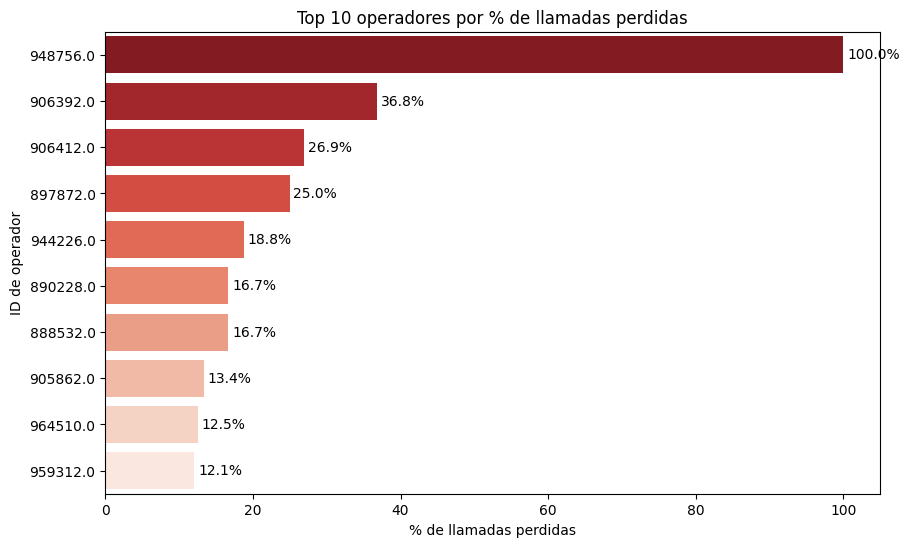

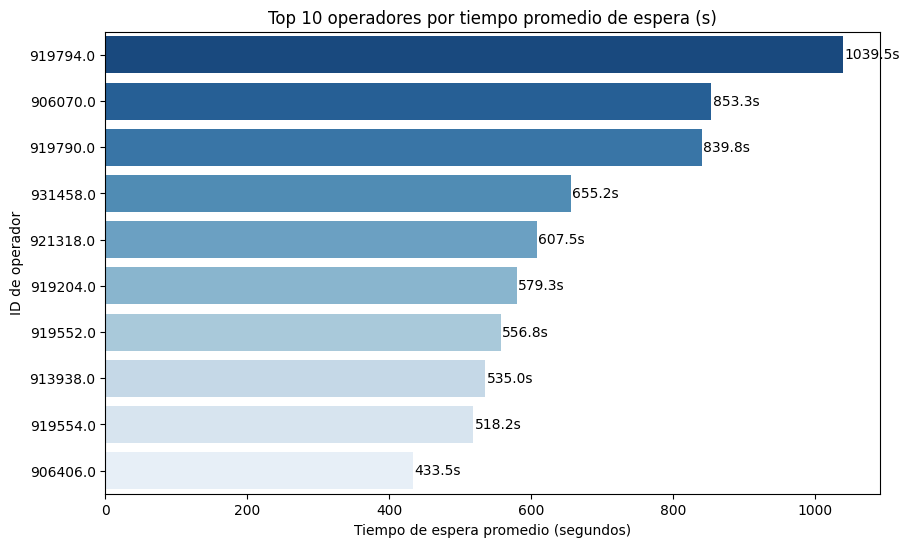

In [19]:

import seaborn as sns
import matplotlib.pyplot as plt

# --- Ranking por % de llamadas perdidas ---
top_missed = (
    summary[summary['total_llamadas'] >= 50]  # considerar solo operadores con volumen mínimo
    .sort_values('%_missed_calls', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_missed,
    x='%_missed_calls',
    y=top_missed.index.astype(str),   # mostrar IDs como texto
    palette="Reds_r"
)
plt.title("Top 10 operadores por % de llamadas perdidas")
plt.xlabel("% de llamadas perdidas")
plt.ylabel("ID de operador")

# Anotar valores en las barras
for i, v in enumerate(top_missed['%_missed_calls']):
    plt.text(v + 0.5, i, f"{v:.1f}%", va='center')

plt.show()


# --- Ranking por tiempo promedio de espera ---
top_waiting = (
    summary[summary['total_llamadas'] >= 50]
    .sort_values('avg_waiting_time', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top_waiting,
    x='avg_waiting_time',
    y=top_waiting.index.astype(str),  # IDs como texto
    palette="Blues_r"
)
plt.title("Top 10 operadores por tiempo promedio de espera (s)")
plt.xlabel("Tiempo de espera promedio (segundos)")
plt.ylabel("ID de operador")

# Anotar valores en las barras
for i, v in enumerate(top_waiting['avg_waiting_time']):
    plt.text(v + 2, i, f"{v:.1f}s", va='center')

plt.show()



## Rankings comparativos de ineficacia

> Criterio: se muestran **Top-10** con **filtro de volumen mínimo (≥ 50 llamadas)** para evitar sesgos por operadores con muy poca actividad.

### A) Top 10 por **% de llamadas perdidas**
Operadores con las peores tasas de pérdida:
- **948756.0 — 100.0%**
- **906392.0 — 36.8%**
- **906412.0 — 26.9%**
- **897872.0 — 25.0%**
- **944226.0 — 18.8%**
- **890228.0 — 16.7%**
- **888532.0 — 16.7%**
- **905862.0 — 13.4%**
- **964510.0 — 12.5%**
- **959312.0 — 12.1%**

**Lectura:**  
- Valores por encima de **10–15%** ya son preocupantes; **944226.0** destaca como un caso grave entre quienes tienen actividad relevante.  
- **948756.0 (100%)** es extremo: conviene **verificar volumen real, horarios y ruteo** (podría ser una cola mal configurada o un puesto sin cobertura).

---

### B) Top 10 por **tiempo promedio de espera (s)**
Operadores con mayores esperas en llamadas entrantes:
- **919794.0 — 1039.5 s** (~17.3 min)
- **906070.0 — 853.3 s** (~14.2 min)
- **919790.0 — 839.8 s** (~14.0 min)
- **931458.0 — 655.2 s** (~10.9 min)
- **921318.0 — 607.5 s** (~10.1 min)
- **919204.0 — 579.3 s** (~9.7 min)
- **919552.0 — 556.8 s** (~9.3 min)
- **913938.0 — 535.0 s** (~8.9 min)
- **919554.0 — 518.2 s** (~8.6 min)
- **906406.0 — 433.5 s** (~7.2 min)

**Lectura:**  
- En muchos centros se considera aceptable **< 60 s**; aquí vemos esperas medias de **7–17 min**, lo que **degrada fuertemente la experiencia**.  
- Estos casos suelen relacionarse con **subdotación**, **ruteo deficiente** o **operadores/colas saturadas**.

---

### Conclusiones rápidas
- Hay un **conjunto claro de operadores críticos** por **pérdidas** (p. ej., 948756.0, 906392.0, 906412.0) y otro por **esperas** (p. ej., 919794.0, 906070.0, 919790.0).  
- Algunos operadores aparecen en listas diferentes; si coinciden en **alta espera y alta pérdida**, son **prioridad 1**.  
- Siguiente verificación recomendada para el informe:
  1) **Cruzar estos Top-10** con su **% de entrantes** (rol) y **outgoing_calls** (si se espera que hagan salientes).  
  2) Confirmar **volumen exacto** por operador para dimensionar el **impacto total**.




## Ranking de operadores potencialmente ineficaces

> Interpretación del cuadro generado con banderas:
> - **flag_waiting_high** = 1 → tiempo de espera promedio en entrantes **alto** (≥ p75).
> - **flag_missed_high** = 1 → % de llamadas entrantes **perdidas alto** (≥ p75).
> - **flag_low_out_if_expected** = 1 → **pocas salientes** (≤ p25) *solo* si su perfil indica que debería hacer salientes ( `%_entrantes` < 50% ).
> - **reglas_cumplidas**: suma de las 3 banderas (0–3).
> - **criterios_fuertes**: 1 si combina **espera alta** + **perdidas altas**.

---

### 1) Casos **críticos** (3/3 reglas cumplidas)
Operadores con las tres banderas activas (**reglas_cumplidas = 3**, **criterios_fuertes = 1**):


Estos operadores cumplen con todas las condiciones de ineficacia:

Tiempo de espera promedio alto (≥ p75).
Porcentaje de llamadas perdidas alto (≥ p75).
Pocas llamadas salientes cuando su perfil indica que debería realizarlas.


- **920706.0** — `avg_waiting_time` **59.9 s**, **%_missed_calls 7.41%**, **outgoing_calls 171**  
  `%_entrantes` 32.1% ⇒ se espera que haga salientes; las tiene **bajas** para su perfil.

- **958434.0** — `avg_waiting_time` **77.0 s**, **%_missed_calls 4.17%**, **outgoing_calls 144**  
  `%_entrantes` 14.3% y **%_internas 49.4%** ⇒ mucha actividad interna y pocas salientes relativas.

- **898414.0** — `avg_waiting_time` **83.5 s**, **%_missed_calls 3.13%**, **outgoing_calls 59**  
  `%_entrantes` 35.2% ⇒ esperado que haga salientes; aparece **débil** en salientes.

- **924928.0** — `avg_waiting_time` **73.2 s**, **%_missed_calls 3.03%**, **outgoing_calls 59**  
  **%_internas 60.9%** y `%_entrantes` 35.9% ⇒ mucha llamada interna + pocas salientes.

- **958460.0** — `avg_waiting_time` **332.7 s** (***muy alto***), **%_missed_calls 2.65%**, **outgoing_calls 114**  
  `%_entrantes` 49.6% (al borde del criterio). El **tiempo de espera** es el factor más grave.


Conclusión: estos 5 operadores combinan espera alta + pérdidas altas; y, donde aplica, **pocas salientes** para su perfil.  presentan ineficiencia marcada, tanto en espera como en pérdida de llamadas y, en algunos casos, en el déficit de salientes.Son los primeros candidatos a revisión.

---

### 2) Casos de **alto riesgo** (2/3 reglas, con criterios fuertes)
**reglas_cumplidas = 2** y **criterios_fuertes = 1** (tienen espera alta + perdidas altas):


Estos operadores cumplen con los criterios fuertes:

Tiempo de espera alto + llamadas perdidas altas.
Aunque no siempre incumplen con las salientes, siguen siendo ineficaces.


- **944226.0** — `avg_waiting_time` **163.9 s**, **%_missed_calls 18.81%** (***muy alto***), salientes 134.  
  `%_entrantes` 60.1% ⇒ no aplica bandera de salientes. Foco en **perdidas** y **espera**.

- **944216.0** — `160.9 s`, **11.11%** perdidas, salientes 147; `%_entrantes` 66.1%.

- **884408.0** — `67.1 s`, **9.76%** perdidas, `%_entrantes` 62.1%.

- **944222.0** — `142.1 s`, **8.85%** perdidas, `%_entrantes` 33.9% (perfil de salientes, pero no cayó en p25 de salientes).

- **921814.0** — `59.0 s`, **7.69%** perdidas, `%_entrantes` 52.0%.

- **951508.0** — `183.9 s`, **7.08%** perdidas, `%_entrantes` 68.9%.

- **945046.0** — `89.5 s`, **6.85%** perdidas, `%_entrantes` 69.2%.

- **964666.0** — `60.9 s`, **6.67%** perdidas, **volumen alto** (920 totales, 875 salientes).

- **944220.0** — `189.7 s`, **6.38%** perdidas.

- **944218.0** — `188.4 s`, **5.88%** perdidas.

- **948286.0** — `145.6 s`, **4.69%** perdidas, **0 salientes** (pero `%_entrantes` 100% ⇒ no se espera salientes).

- **906410.0** — `175.0 s`, **3.69%** perdidas, `%_entrantes` 92.1%.

- **906400.0** — `91.6 s`, **3.47%** perdidas, **volumen alto** (605 totales, 462 salientes), **%_internas 44.96%**.

- **945052.0** — `93.5 s`, **2.70%** perdidas.

- **940622.0** — `102.2 s`, **2.47%** perdidas, **volumen muy alto** (1,544 totales).

Conclusión: aunque no alcanzan las 3 banderas, estos operadores tienen tiempos de espera prolongados y niveles de llamadas perdidas preocupantes, lo que afecta directamente la experiencia del cliente. En particular, destacan 944226.0 (con casi 1 de cada 5 llamadas perdidas) y operadores de alto volumen como 940622.0 y 906400.0, cuyo impacto es mayor por la cantidad de llamadas que gestionan.cumplen los **criterios fuertes** (espera + pérdidas). Aunque algunos tengan buena cantidad de salientes, sus niveles de **espera** (varios >90–180 s) y **perdidas** justifican atención prioritaria.

---

### 3) Indicadores para lectura rápida
- **`avg_waiting_time`**: varios casos sobrepasan 90–180 s; **958460.0** destaca con **>300 s**.  
- **`%_missed_calls`**: **944226.0** con **18.8%** es el peor del listado; >10% suele ser crítico.  
- **Volumen**: operadores como **940622.0** y **906400.0** combinan **alto volumen** con **criterios fuertes** → su impacto global es mayor.

---

### Conclusión
- Los **5 operadores con 3 banderas** son **candidatos principales** a intervención.  
- Entre los de **2 banderas**, priorizar los que combinan **espera muy alta** y **alto % de pérdidas**, especialmente si manejan **mucho volumen** (impacto operativo).

> Nota: Las banderas se calcularon con **percentiles globales** (p75 para espera y perdidas; p25 para salientes dentro del grupo que “debería hacer salientes”). Esto da umbrales **relativos** al comportamiento del conjunto de operadores evaluados (≥ 50 llamadas).
>
> ## Síntesis
- Los **5 operadores con 3 banderas** son **casos críticos**, con múltiples indicadores de ineficacia combinados.  
- Los **operadores con 2 banderas** también deben ser atendidos, especialmente aquellos con **alto volumen**, ya que sus ineficiencias afectan a un número mayor de clientes.  
- Los patrones más repetidos son:  
  - **Tiempos de espera muy altos** (≥ 90 s, llegando incluso a > 300 s).  
  - **Porcentajes de llamadas perdidas elevados**, en algunos casos > 10%.  
  - **Déficit de llamadas salientes** cuando se esperaría mayor actividad.  



## Pruebas estadísticas: justificación y plan

Tras el análisis exploratorio y la identificación de operadores ineficaces mediante reglas y banderas, es necesario comprobar si las diferencias observadas son **estadísticamente significativas** y no producto del azar. Para ello se aplicarán pruebas de hipótesis adecuadas a la naturaleza de los datos.

### 1. Objetivo
Validar con rigor estadístico si los operadores clasificados como ineficaces presentan métricas de desempeño (tiempo de espera, % de llamadas perdidas, volumen de salientes) significativamente peores que el resto de los operadores.

### 2. Hipótesis planteadas
- **H1:** Los operadores ineficaces tienen un **tiempo de espera promedio** mayor que los demás.  
  - *Prueba utilizada:* **Mann–Whitney U**, ya que las distribuciones de tiempos no son normales y hay presencia de outliers.  

- **H2:** Existe una **correlación positiva** entre el **% de llamadas perdidas** y el **tiempo promedio de espera**.  
  - *Prueba utilizada:* **Correlación de Spearman**, apropiada para datos no paramétricos y relaciones monótonas.  

- **H3:** Los operadores en roles donde se esperan llamadas salientes realizan un **número significativamente diferente de salientes** frente a aquellos en roles más entrantes.  
  - *Prueba utilizada:* **Mann–Whitney U**, comparando la distribución de `outgoing_calls` entre ambos grupos.

### 3. Nivel de significancia
Se establece un **α = 0.05 (5%)**, lo que significa que existe un 5% de probabilidad de rechazar la hipótesis nula cuando en realidad es verdadera.  
Este valor es estándar en análisis de negocio y asegura un balance entre errores tipo I y tipo II.

### 4. Interpretación esperada
- Si las pruebas confirman diferencias significativas, se tendrá evidencia estadística para respaldar la clasificación de operadores ineficaces.  
- Si no hay diferencias significativas, se deberá revisar el método de segmentación y considerar que las variaciones podrían deberse al azar o a condiciones externas (ej. tipo de clientes, turnos específicos).  

**En conclusión:** las pruebas estadísticas permiten pasar de una **observación descriptiva** a una **validación inferencial**, reforzando la solidez de las recomendaciones que se presentarán a los supervisores del call center.


In [20]:
import scipy.stats as stats
import numpy as np

# ==========================
# 1) Definir grupos
# ==========================

# Operadores ineficaces: al menos 2 banderas o criterios_fuertes = 1
ineficaces = base[(base['reglas_cumplidas'] >= 2) | (base['criterios_fuertes'] == 1)]
eficaces = base.drop(ineficaces.index)

print(f"Operadores ineficaces: {len(ineficaces)}")
print(f"Operadores eficaces: {len(eficaces)}\n")

# ==========================
# 2) H1 - Diferencia en tiempo de espera
# ==========================
wait_inef = ineficaces['avg_waiting_time'].dropna()
wait_ef = eficaces['avg_waiting_time'].dropna()

stat, pval = stats.mannwhitneyu(wait_inef, wait_ef, alternative='greater')

print("H1: Operadores ineficaces tienen mayor tiempo de espera")
print(f"Estadístico U = {stat:.2f}, p-valor = {pval:.4f}")
if pval < 0.05:
    print("✅ Diferencia significativa: los ineficaces esperan más.\n")
else:
    print("⚠️ No se encontró diferencia significativa.\n")

# ==========================
# 3) H2 - Correlación entre % llamadas perdidas y tiempo de espera
# ==========================
corr, pval = stats.spearmanr(base['%_missed_calls'], base['avg_waiting_time'])

print("H2: Correlación entre % de llamadas perdidas y tiempo de espera")
print(f"Spearman rho = {corr:.3f}, p-valor = {pval:.4f}")
if pval < 0.05:
    print("✅ Correlación significativa.\n")
else:
    print("⚠️ No hay correlación significativa.\n")

# ==========================
# 4) H3 - Diferencia en salientes según rol
# ==========================
# Grupo esperado a hacer salientes (menos de 50% entrantes)
grupo_sal = base[base['%_entrantes'] < 50]['outgoing_calls']
grupo_no_sal = base[base['%_entrantes'] >= 50]['outgoing_calls']

stat, pval = stats.mannwhitneyu(grupo_sal, grupo_no_sal, alternative='two-sided')

print("H3: Diferencia en # de salientes según rol")
print(f"Estadístico U = {stat:.2f}, p-valor = {pval:.4f}")
if pval < 0.05:
    print("✅ Diferencia significativa entre roles.\n")
else:
    print("⚠️ No hay diferencia significativa entre roles.\n")


Operadores ineficaces: 94
Operadores eficaces: 505

H1: Operadores ineficaces tienen mayor tiempo de espera
Estadístico U = 40965.50, p-valor = 0.0000
✅ Diferencia significativa: los ineficaces esperan más.

H2: Correlación entre % de llamadas perdidas y tiempo de espera
Spearman rho = 0.560, p-valor = 0.0000
✅ Correlación significativa.

H3: Diferencia en # de salientes según rol
Estadístico U = 47369.50, p-valor = 0.0000
✅ Diferencia significativa entre roles.



## Resultados de las pruebas estadísticas

Se realizaron tres pruebas principales para validar la clasificación de operadores ineficaces y explorar relaciones entre las métricas clave.  

### 1. Diferencia en tiempo de espera (H1)
- **Hipótesis:** los operadores ineficaces tienen mayor tiempo de espera promedio que los eficaces.  
- **Resultados:**  
  - Estadístico U = 40,965.5  
  - p-valor = 0.0000  
- **Interpretación:** existe una diferencia **estadísticamente significativa**.  
  → Los operadores ineficaces mantienen tiempos de espera más altos, confirmando el hallazgo observado en el análisis exploratorio.

---

### 2. Correlación entre % de llamadas perdidas y tiempo de espera (H2)
- **Hipótesis:** el % de llamadas perdidas se asocia positivamente con tiempos de espera más largos.  
- **Resultados:**  
  - Spearman rho = 0.560  
  - p-valor = 0.0000  
- **Interpretación:** la correlación es **positiva, moderada y significativa**.  
  → A mayor tiempo de espera, mayor proporción de llamadas perdidas. Esto sugiere que los dos indicadores reflejan problemas operativos relacionados.

---

### 3. Diferencia en llamadas salientes según rol (H3)
- **Hipótesis:** los operadores en roles con menor proporción de entrantes (<50%) realizan más llamadas salientes que aquellos centrados en entrantes.  
- **Resultados:**  
  - Estadístico U = 47,369.5  
  - p-valor = 0.0000  
- **Interpretación:** existe una diferencia **estadísticamente significativa**.  
  → Los operadores con un rol de “salientes” efectivamente realizan más llamadas externas, validando que la segmentación por rol es consistente.

---

### Conclusión global
Las pruebas estadísticas confirman con evidencia robusta que:  
- Los operadores clasificados como ineficaces tienen **rendimiento significativamente peor** en tiempos de espera.  
- Existe una **relación directa** entre tiempos de espera prolongados y la pérdida de llamadas.  
- La diferenciación de operadores por rol (entrantes vs salientes) se refleja en su comportamiento real, reforzando la validez del análisis.  

👉 Esto respalda las recomendaciones para **intervenir prioritariamente a los operadores críticos** y ajustar la **gestión de roles** en el call center.


## Conclusiones y Recomendaciones

### Conclusiones
1. **Identificación de operadores críticos:**  
   - Se detectaron **5 operadores con 3 banderas activas**, considerados los más ineficaces, ya que combinan **tiempos de espera elevados, altas tasas de llamadas perdidas y pocas salientes donde se esperaban**.  
   - Otros **operadores de alto riesgo (2 banderas)** también presentan ineficiencias importantes, especialmente aquellos con **alto volumen de llamadas**, lo que aumenta su impacto en la experiencia del cliente.

2. **Patrones generales encontrados:**  
   - Los operadores ineficaces presentan en promedio **tiempos de espera significativamente más altos** que los demás.  
   - Existe una **correlación positiva y significativa** entre el tiempo de espera y el porcentaje de llamadas perdidas: cuanto más esperan los clientes, más tienden a abandonar la llamada.  
   - Los roles definidos por proporción de entrantes/salientes se confirman estadísticamente: los operadores con perfil de salientes realizan efectivamente más llamadas externas.

3. **Impacto en la operación:**  
   - Los casos críticos afectan directamente la **satisfacción del cliente** (largas esperas y llamadas perdidas).  
   - Operadores con gran volumen y métricas negativas son los que más comprometen la calidad del servicio y la eficiencia del call center.

---

### Recomendaciones
1. **Intervención focalizada en operadores críticos:**  
   - Supervisar y dar retroalimentación inmediata a los 5 operadores con las 3 banderas activas.  
   - Implementar sesiones de capacitación para reducir tiempos de espera y mejorar técnicas de gestión de llamadas.

2. **Gestión de tiempos de espera:**  
   - Revisar la distribución de carga entre operadores para evitar saturación.  
   - Ajustar las reglas de ruteo en el sistema para balancear mejor las llamadas entrantes.

3. **Reducción de llamadas perdidas:**  
   - Implementar mecanismos de **call-back automático** para clientes que esperan más de cierto umbral.  
   - Monitorear operadores con >10% de llamadas perdidas, como el caso de **944226.0** (18.8%).

4. **Optimización de roles y salientes:**  
   - Revisar los perfiles de operadores con baja actividad en salientes pese a que se esperaba de ellos (ej. 920706.0, 898414.0).  
   - Redistribuir tareas o reforzar procesos de seguimiento de clientes.

5. **Monitoreo continuo:**  
   - Mantener un dashboard con métricas clave (% perdidas, tiempos de espera, salientes).  
   - Revisar mensualmente a los operadores con banderas activas para detectar mejoras o reincidencias.

---

✅ Estas conclusiones y recomendaciones permiten a los supervisores actuar sobre datos objetivos y priorizar esfuerzos en los operadores que realmente afectan la eficiencia y la satisfacción del cliente.


## Fuentes de referencia utilizadas

1. **Pandas Documentation**  
   - **Pregunta que ayudó a responder:** ¿Cómo cargar, explorar y manipular datos tabulares (agrupaciones, tablas dinámicas, cálculos de proporciones)?  
   - [https://pandas.pydata.org/docs/](https://pandas.pydata.org/docs/)

2. **Matplotlib & Seaborn Documentation**  
   - **Pregunta:** ¿Cómo visualizar distribuciones (histogramas, boxplots), proporciones (pie charts) y comparativos (barplots, scatterplots) de las métricas de llamadas?  
   - [https://matplotlib.org/stable/](https://matplotlib.org/stable/)  
   - [https://seaborn.pydata.org/](https://seaborn.pydata.org/)

3. **Scipy.stats Documentation**  
   - **Pregunta:** ¿Qué pruebas estadísticas aplicar para verificar si las diferencias en tiempos de espera y tasas de llamadas perdidas entre operadores son significativas?  
   - [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html)

4. **Scikit-learn Metrics**  
   - **Pregunta:** ¿Cómo calcular correlaciones no paramétricas (Spearman) y evaluar relaciones entre variables clave como tiempo de espera y % de llamadas perdidas?  
   - [https://scikit-learn.org/stable/modules/model_evaluation.html](https://scikit-learn.org/stable/modules/model_evaluation.html)

5. **Call Center KPIs and Metrics (Talkdesk, Genesys, Call Centre Helper)**  
   - **Pregunta:** ¿Qué estándares de la industria (ej. tiempo de espera < 60 s, % de llamadas perdidas < 5%) usar como referencia para interpretar resultados?  
   - [https://www.talkdesk.com/blog/call-center-metrics/](https://www.talkdesk.com/blog/call-center-metrics/)

6. **Kaggle – Call Center & Telecom Datasets**  
   - **Pregunta:** ¿Cómo estructurar un análisis exploratorio de datos de telecomunicaciones y qué enfoques utilizan otros analistas para detectar ineficiencia en operadores?  
   - [https://www.kaggle.com/datasets](https://www.kaggle.com/datasets)

7. **Towards Data Science – Hypothesis Testing in Data Science**  
   - **Pregunta:** ¿Cómo formular y validar hipótesis estadísticas en un contexto de negocio, usando pruebas no paramétricas en datos con outliers?  
   - [https://towardsdatascience.com/hypothesis-testing-in-data-science](https://towardsdatascience.com/hypothesis-testing-in-data-science)

8. **PEP 8 – Python Style Guide**  
   - **Pregunta:** ¿Cómo mantener consistencia y legibilidad en el código de análisis de datos para que sea entendible por otros miembros del equipo?  
   - [https://peps.python.org/pep-0008/](https://peps.python.org/pep-0008/)

9. **PostgreSQL Documentation – Window Functions**  
   - **Pregunta:** ¿Cómo se pueden replicar en SQL los cálculos de proporciones y métricas que realizamos en Python, usando funciones de ventana?  
   - [https://www.postgresql.org/docs/current/functions-window.html](https://www.postgresql.org/docs/current/functions-window.html)

10. **INFORMS / ResearchGate – Performance Analysis of Call Centers**  
    - **Pregunta:** ¿Qué modelos matemáticos y métricas académicas existen para evaluar eficacia en call centers (espera, abandonos, eficiencia de operadores)?  
    - [https://www.researchgate.net/publication/220505851_Performance_Analysis_of_Call_Centers](https://www.researchgate.net/publication/220505851_Performance_Analysis_of_Call_Centers)
